# Renew Home Data Assignment

## Step 1: Import data to Google Cloud bucket and insert into BigQuery database

In [ ]:
### Library Imports
from google.cloud import bigquery
from google.cloud import storage
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Setting bucket and file variables
bucket_name = "renew-home-sample"
project="loyal-burner-462818-m3"
device_participation_filepath = os.environ.get('DEVICE_PARTICIPATION')
device_participation_blob_name = "device_participation.csv.gz"
home_filepath = os.environ.get('HOME')
home_blob_name = "home.csv.gz"
device_filepath = os.environ.get('DEVICE')
device_blob_name = "device.csv.gz"
file_dictionary = {device_participation_filepath:device_participation_blob_name,
                   home_filepath:home_blob_name,
                   device_filepath:device_blob_name}

# Uploading files to Google Cloud storage bucket
storage_client = storage.Client(project=project)
bucket = storage_client.bucket(bucket_name)

for path in file_dictionary:
    blob = bucket.blob(file_dictionary[path])
    blob.upload_from_filename(path)

In [ ]:
# Create initial dataset for VPP analysis
client = bigquery.Client(project=project)
dataset_name = "VPP"
dataset_id = "{}.{}".format(client.project, dataset_name)

# Construct a full Dataset object to send to the API.
dataset = bigquery.Dataset(dataset_id)

dataset.location = "US"

# Send the dataset to the API for creation, with an explicit timeout.
# Raises google.api_core.exceptions.Conflict if the Dataset already
# exists within the project.
dataset = client.create_dataset(dataset, timeout=30)  # Make an API request.
print("Created dataset {}.{}".format(client.project, dataset.dataset_id))

Created dataset loyal-burner-462818-m3.VPP


In [ ]:
# Create tables wihtin VPP dataset
client = bigquery.Client(project=project)

file_list = ['device_participation','home','device']
for file in file_list:
    table_id = "{}.{}.{}".format(client.project,dataset_name,file)

    job_config = bigquery.LoadJobConfig(
        autodetect=True
    )
    uri = "gs://renew-home-sample/{}.csv.gz".format(file)

    load_job = client.load_table_from_uri(
        uri, table_id, job_config=job_config
    ) 

    load_job.result() 

    destination_table = client.get_table(table_id) 
    print("Loaded {} rows to {}".format(destination_table.num_rows,table_id))


Loaded 177242 rows to loyal-burner-462818-m3.VPP.device_participation


## Step 2 - SQL queries to summarize datasets

In [81]:
# count of unique device events query
sql = """
SELECT count(*) 
FROM 
(SELECT distinct device_id, event_id, shift_id FROM `loyal-burner-462818-m3.VPP.device_participation`)
"""

full_participation_df = client.query(sql).to_dataframe(create_bqstorage_client=False)

print(full_participation_df.head())

      f0_
0  177242


In [ ]:
# count of unique device events query with start/end times
sql = """
SELECT count(*) 
FROM 
(SELECT distinct device_id, event_id, shift_id FROM `loyal-burner-462818-m3.VPP.device_participation`
WHERE actual_start_time is not null AND actual_end_time is not null)
"""

actual_participation_df = client.query(sql).to_dataframe(create_bqstorage_client=False)

print(actual_participation_df.head())

# rate of event failure
print(1-(actual_participation_df/full_participation_df))

      f0_
0  112438
        f0_
0  0.365624


In [40]:
# count of unique devices query
sql = """
SELECT count(distinct(device_id)) 
FROM `loyal-burner-462818-m3.VPP.device`
"""

df = client.query(sql).to_dataframe(create_bqstorage_client=False)

print(df.head())

    f0_
0  2469


In [41]:
# duplicate device query
sql = """
    SELECT device_id, count(device_id) 
    FROM `loyal-burner-462818-m3.VPP.device` 
    GROUP BY device_id HAVING count(device_id) > 1 LIMIT 1000
"""

df = client.query(sql).to_dataframe(create_bqstorage_client=False)

print(df.head())

                          device_id  f0_
0  35e6ed02e77b52c75d511d229489ba05    2
1  b961183f4daf8e39d4f5ac0c2033db54    2
2  88de206d34258b7dfd387a4e8e6afe86    2
3  5098a0c3527eff25d9a64b1e035093f4    2


In [42]:
# count of unique homes query
sql = """
SELECT count(distinct(home_id)) 
FROM `loyal-burner-462818-m3.VPP.home`
"""

df = client.query(sql).to_dataframe(create_bqstorage_client=False)

print(df.head())

    f0_
0  1764


In [84]:
# feature percentage query
sql = """
SELECT feature, count(feature), count(feature)/sum(count(feature)) OVER() 
FROM `loyal-burner-462818-m3.VPP.device_participation`
WHERE actual_start_time is not null AND actual_end_time is not null
GROUP BY feature
"""

df = client.query(sql).to_dataframe(create_bqstorage_client=False)

print(df.head())

                         feature     f0_       f1_
0  DEVICE_SHIFT_TYPE_TIME_OF_USE    3237  0.028789
1    DEVICE_SHIFT_TYPE_EMISSIONS  109201  0.971211


In [85]:
# opt out percentage query
sql = """
SELECT opted_out, count(opted_out), count(opted_out)/sum(count(opted_out)) OVER()
FROM `loyal-burner-462818-m3.VPP.device_participation`
WHERE actual_start_time is not null AND actual_end_time is not null
GROUP BY opted_out
"""

df = client.query(sql).to_dataframe(create_bqstorage_client=False)

print(df.head())

   opted_out     f0_       f1_
0          0  106683  0.948816
1          1    5755  0.051184


In [86]:
# start/end time difference query
sql = """
SELECT AVG(TIMESTAMP_DIFF(actual_start_time, planned_start_time, MINUTE)) as start_difference, 
AVG(TIMESTAMP_DIFF(actual_end_time, planned_end_time, MINUTE)) as end_difference 
FROM `loyal-burner-462818-m3.VPP.device_participation` WHERE opted_out = 0 and actual_start_time is not null AND actual_end_time is not null
"""

df = client.query(sql).to_dataframe(create_bqstorage_client=False)

print(df.head())

   start_difference  end_difference
0           0.27712       -0.320088


In [87]:
# average event length
sql = """
SELECT AVG(TIMESTAMP_DIFF(actual_end_time, actual_start_time, MINUTE)) as actual_event_length
FROM `loyal-burner-462818-m3.VPP.device_participation` WHERE opted_out = 0 and actual_start_time is not null AND actual_end_time is not null
"""

df = client.query(sql).to_dataframe(create_bqstorage_client=False)

print(df.head())

   actual_event_length
0            52.448422


In [88]:
# events by month query
sql = """
SELECT FORMAT_DATETIME('%m%Y', actual_end_time) AS month, count(FORMAT_DATETIME('%m%Y', actual_end_time)) as event_count
FROM `loyal-burner-462818-m3.VPP.device_participation` 
WHERE actual_start_time is not null AND actual_end_time is not null
GROUP BY FORMAT_DATETIME('%m%Y', actual_end_time)
"""

monthly_event_df = client.query(sql).to_dataframe(create_bqstorage_client=False)

print(monthly_event_df)

    month  event_count
0  022025        26770
1  032025        20643
2  042025        29991
3  052025        35034


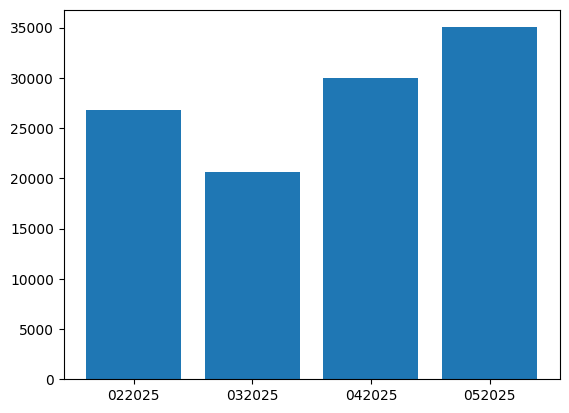

In [ ]:
# plot of events over the past few months
plt.bar(monthly_event_df['month'], monthly_event_df['event_count'])
plt.show()

## Step 3 - Exploratory data analysis in pandas

In [ ]:
# pulling full tables into dataframes

sql = """
SELECT *
FROM `loyal-burner-462818-m3.VPP.device`
"""

device_df = client.query(sql).to_dataframe(create_bqstorage_client=False)

sql = """
SELECT *
FROM `loyal-burner-462818-m3.VPP.home`
"""

home_df = client.query(sql).to_dataframe(create_bqstorage_client=False)

sql = """
SELECT *
FROM `loyal-burner-462818-m3.VPP.device_participation`
"""

device_participation_full_df = client.query(sql).to_dataframe(create_bqstorage_client=False)

sql = """
SELECT *
FROM `loyal-burner-462818-m3.VPP.device_participation`
WHERE actual_start_time is not null AND actual_end_time is not null
"""

device_participation_with_start_end_df = client.query(sql).to_dataframe(create_bqstorage_client=False)

In [97]:
# merge/join device participation to device
combined_device_participation_full_df = pd.merge(device_participation_full_df, device_df, left_on='device_id', right_on='device_id')

# merge/join device participation to home
final_combined_full_df = pd.merge(combined_device_participation_full_df, home_df, left_on='home_id', right_on='home_id')

# merge/join device participation to device
combined_device_participation_with_start_end_df = pd.merge(device_participation_with_start_end_df, device_df, left_on='device_id', right_on='device_id')

# merge/join device participation to home
final_combined_with_start_end_df = pd.merge(combined_device_participation_with_start_end_df, home_df, left_on='home_id', right_on='home_id')

print(final_combined_with_start_end_df.columns)

Index(['device_id', 'event_id', 'shift_id', 'feature', 'planned_start_time',
       'planned_end_time', 'actual_start_time', 'actual_end_time', 'opted_out',
       'home_id', 'create_date', 'device_type', 'device_model', 'device_state',
       'timezone', 'emissions_shift_enabled', 'time_of_use_shift_enabled'],
      dtype='object')


In [98]:
# looking at device opt-out by device_type
device_opt_out = final_combined_full_df.groupby(['device_model','opted_out']).size().unstack().reset_index()
device_opt_out.rename(columns={0:'opted_in',1:'opted_out'}, inplace=True)
device_opt_out['opt_out_rate'] = device_opt_out['opted_out'] / (device_opt_out['opted_in'] + device_opt_out['opted_out'])
print(device_opt_out)

opted_out device_model  opted_in  opted_out  opt_out_rate
0                    A     40326       1632      0.038896
1                    B     27632       1090      0.037950
2                    C     95578       2833      0.028787
3                    D      8004        295      0.035546


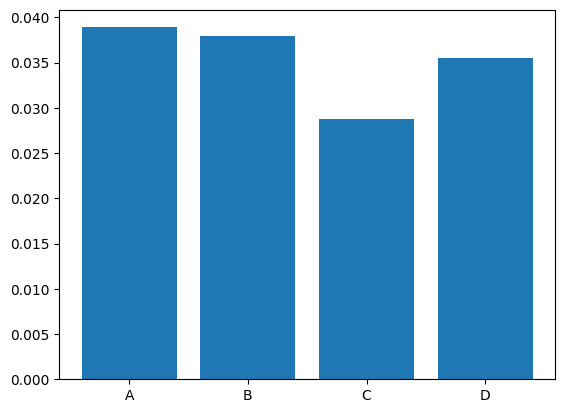

In [ ]:
# plot of opt-out rate over the past few months
plt.bar(device_opt_out['device_model'], device_opt_out['opt_out_rate'])
plt.show()

In [100]:
# looking at device opt-out by device_type with start/end included
device_opt_out = final_combined_with_start_end_df.groupby(['device_model','opted_out']).size().unstack().reset_index()
device_opt_out.rename(columns={0:'opted_in',1:'opted_out'}, inplace=True)
device_opt_out['opt_out_rate'] = device_opt_out['opted_out'] / (device_opt_out['opted_in'] + device_opt_out['opted_out'])
print(device_opt_out)

opted_out device_model  opted_in  opted_out  opt_out_rate
0                    A     30368       1623      0.050733
1                    B     18701       1046      0.052970
2                    C     52580       2821      0.050920
3                    D      5057        294      0.054943


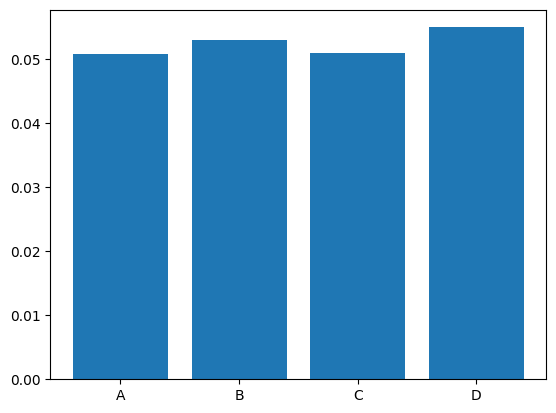

In [ ]:
# plot of opt-out rate over the past few months
plt.bar(device_opt_out['device_model'], device_opt_out['opt_out_rate'])
plt.show()

In [102]:
# looking at device opt-out by device_type by month
final_combined_with_start_end_df['event_month'] = pd.to_datetime(final_combined_with_start_end_df['actual_end_time']).dt.month
device_opt_out = final_combined_with_start_end_df.groupby(['device_model','event_month','opted_out']).size().unstack().reset_index()
device_opt_out.rename(columns={0:'opted_in',1:'opted_out'}, inplace=True)
device_opt_out['opt_out_rate'] = device_opt_out['opted_out'] / (device_opt_out['opted_in'] + device_opt_out['opted_out'])
print(device_opt_out)

opted_out device_model  event_month  opted_in  opted_out  opt_out_rate
0                    A            2      7340        477      0.061021
1                    A            3      5736        369      0.060442
2                    A            4      7868        399      0.048264
3                    A            5      9424        378      0.038564
4                    B            2      4284        316      0.068696
5                    B            3      3229        232      0.067033
6                    B            4      5066        249      0.046849
7                    B            5      6122        249      0.039083
8                    C            2     12183        747      0.057773
9                    C            3      9587        573      0.056398
10                   C            4     14210        728      0.048735
11                   C            5     16600        773      0.044494
12                   D            2      1333        101      0.070432
13    

In [105]:
homes_with_emissions_shift = home_df['emissions_shift_enabled'].value_counts(normalize=True)
print(homes_with_emissions_shift)

homes_with_tou_shift = home_df['time_of_use_shift_enabled'].value_counts(normalize=True)
print(homes_with_tou_shift)

emissions_shift_enabled
True     0.977891
False    0.022109
Name: proportion, dtype: Float64
time_of_use_shift_enabled
False    0.970522
True     0.029478
Name: proportion, dtype: Float64


In [110]:
# looking at device opt-out by timezone
device_opt_out = final_combined_with_start_end_df.groupby(['timezone','opted_out']).size().unstack().reset_index()
device_opt_out.rename(columns={0:'opted_in',1:'opted_out'}, inplace=True)
device_opt_out['opt_out_rate'] = device_opt_out['opted_out'] / (device_opt_out['opted_in'] + device_opt_out['opted_out'])
device_opt_out_sorted = device_opt_out.sort_values(by='opted_in',ascending=False).reset_index(drop=True)
device_opt_out_sorted = device_opt_out_sorted.iloc[0:6]
print(device_opt_out_sorted)

opted_out             timezone  opted_in  opted_out  opt_out_rate
0             America/New_York     41693       1966      0.045031
1              America/Chicago     30394       1814      0.056321
2          America/Los_Angeles     14744       1260      0.078730
3               America/Denver      8883        312      0.033931
4              America/Detroit      4515        146      0.031324
5              America/Phoenix      2621        106      0.038871


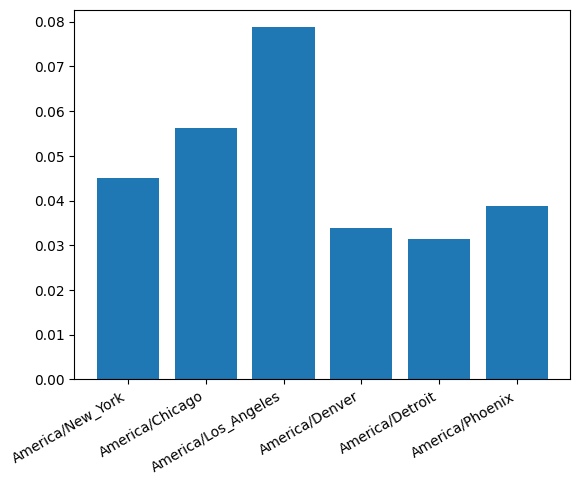

In [115]:
# plot of events over the past few months
plt.bar(device_opt_out_sorted['timezone'], device_opt_out_sorted['opt_out_rate'])
plt.xticks(rotation=30, ha='right')
plt.show()

In [126]:
# event failed rate by device_model
final_combined_full_df['event_failed'] = np.where(~((~final_combined_full_df['actual_start_time'].isna()) & (~final_combined_full_df['actual_end_time'].isna())),1,0)
fail_rate = final_combined_full_df['event_failed'].value_counts(normalize=True)
print(fail_rate)

device_failed = final_combined_full_df.groupby(['device_model','event_failed']).size().unstack().reset_index()
device_failed.rename(columns={0:'event_succeded',1:'event_failed'}, inplace=True)
device_failed['fail_rate'] = device_failed['event_failed'] / (device_failed['event_succeded'] + device_failed['event_failed'])
print(device_failed)

event_failed
0    0.634139
1    0.365861
Name: proportion, dtype: float64
event_failed device_model  event_succeded  event_failed  fail_rate
0                       A           31991          9967   0.237547
1                       B           19747          8975   0.312478
2                       C           55401         43010   0.437045
3                       D            5351          2948   0.355224
